## Build Log

In [1]:
zero_frac = 0.25
correction = 0.15

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
driving_log = pd.read_csv('data/driving_log.csv', usecols=['center', 'left', 'right', 'steering']) #['throttle', 'brake', 'speed']
driving_log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [4]:
driving_log['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

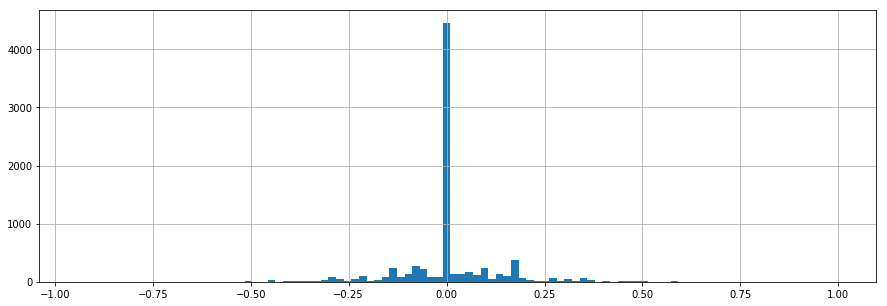

In [5]:
_ = driving_log['steering'].hist(bins=100, figsize=(15,5))

In [6]:
def undersample_zero_steerings(log, frac):
    log_nonzero = log[log['steering']!=0]
    log_zero = log[log['steering']==0].sample(frac=frac)
    log = log_zero.append(log_nonzero)
    log = log.reset_index(drop=True)
    return log

In [7]:
driving_log = undersample_zero_steerings(driving_log, zero_frac)

In [8]:
driving_log['steering'].describe()

count    4765.000000
mean        0.006863
std         0.167267
min        -0.942695
25%        -0.069252
50%         0.000000
75%         0.090465
max         1.000000
Name: steering, dtype: float64

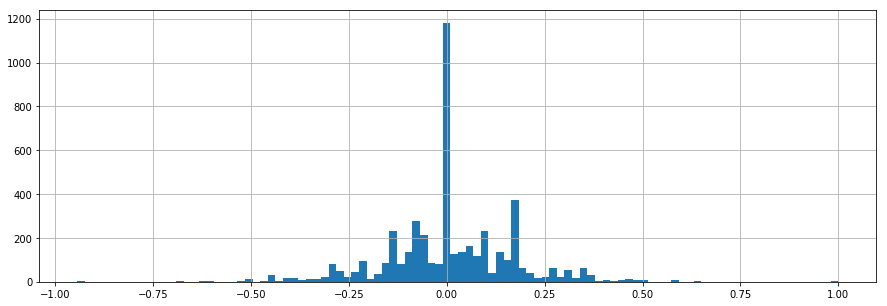

In [9]:
_ = driving_log['steering'].hist(bins=100, figsize=(15,5))

In [10]:
def augment_left_right(driving_log, correction):
    log = pd.DataFrame({'image':driving_log['center']
                                .append(driving_log['left'])
                                .append(driving_log['right']),
                        'steering':driving_log['steering']
                                .append(driving_log['steering'] + correction)
                                .append(driving_log['steering'] - correction)})

    log = log[(log['steering']>=-1)&(log['steering']<=1)]
    return log

In [11]:
log = augment_left_right(driving_log, correction)

In [12]:
log['steering'].describe()

count    14289.000000
mean         0.007009
std          0.206098
min         -0.959811
25%         -0.150000
50%          0.000000
75%          0.150000
max          1.000000
Name: steering, dtype: float64

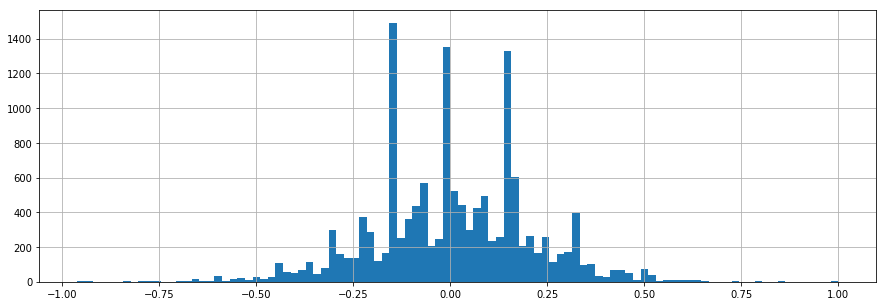

In [13]:
_ = log['steering'].hist(bins=100, figsize=(15,5))

In [14]:
log = log.sample(frac=1).reset_index(drop=True)  #shuffle log DataFrame

## Build Training and Validation Data

In [15]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn

%matplotlib inline

Using TensorFlow backend.


In [16]:
log.head()

,image,steering
0,IMG/left_2016_12_01_13_36_47_521.jpg,0.150000
1,IMG/center_2016_12_01_13_45_14_633.jpg,-0.078746
2,IMG/center_2016_12_01_13_43_50_250.jpg,-0.059757
3,IMG/right_2016_12_01_13_46_14_312.jpg,-0.150000
4,IMG/center_2016_12_01_13_37_43_385.jpg,-0.145206


In [17]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[:,:,None]
    
    return image

In [18]:
def get_data(log, correction = 0.08):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename = 'data/'+row['image'].strip()
        image = preprocess(mpimg.imread(filename))
        image_flip = cv2.flip(image, 1)[:,:,None]
        steering = row['steering']

        images.extend([image, image_flip])
        steerings.extend([steering, -steering])

    X_train, y_train = np.array(images), np.array(steerings)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    
    return X_train, y_train

In [19]:
train_log, validation_log = train_test_split(log, test_size=0.0001)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

In [20]:
log.shape, train_log.shape, validation_log.shape

((14289, 2), (14287, 2), (2, 2))

In [21]:
def generator(sample_log, batch_size=32):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            
            end_offset = offset + batch_size
            #if end_offset > n_rows:
            #    end_offset = n_rows
            
            batch_log = sample_log[offset : end_offset]

            X, y = get_data(batch_log)
            
            yield X, y 

In [22]:
train_generator = generator(train_log, batch_size=128)
validation_generator = generator(validation_log, batch_size=128)

## Compile and train the model

In [23]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,1)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2) 

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=3,
                                     verbose=1)

Epoch 1/3
14336/14287 [==============================] - 214s - loss: 0.0275 - val_loss: 0.0381

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/3
14494/14287 [==============================] - 219s - loss: 0.0162 - val_loss: 0.0279

In [24]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


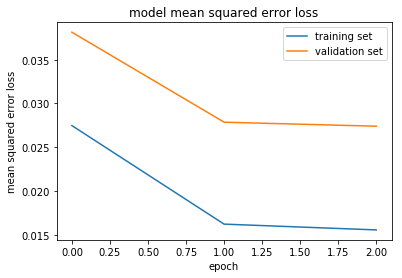

In [25]:
### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')